In [1]:
# Load the libraries
pacman::p_load(latex2exp,ggplot2,grid,dplyr,GGally, RColorBrewer,SPADAR, sphereplot,
               nortest,gridExtra,mclust,caret, earth, hdrcde, mclust, spatstat)

# Read data
temp <- read.table('apotgas.csv', sep=",",header=TRUE,stringsAsFactors=FALSE)

# Provide a summary of the data
names(temp)

[1] "APSTAR_ID"                     "TARGET_ID"                    
  [3] "ASPCAP_ID"                     "FILE"                         
  [5] "APOGEE_ID"                     "TELESCOPE"                    
  [7] "LOCATION_ID"                   "FIELD"                        
  [9] "J"                             "J_ERR"                        
 [11] "H"                             "H_ERR"                        
 [13] "K"                             "K_ERR"                        
 [15] "RA"                            "DEC"                          
 [17] "GLON"                          "GLAT"                         
 [19] "APOGEE_TARGET1"                "APOGEE_TARGET2"               
 [21] "APOGEE_TARGET3"                "TARGFLAGS"                    
 [23] "SURVEY"                        "NINST"                        
 [25] "NVISITS"                       "COMBTYPE"                     
 [27] "COMMISS"                       "SNR"                          
 [29] "STARFLAG"                      "STARFLAGS"                    
 [31] "ANDFLAG"                       "ANDFLAGS"                     
 [33] "VHELIO_AVG"                    "VSCATTER"                     
 [35] "VERR"                          "VERR_MED"                     
 [37] "OBSVHELIO_AVG"                 "OBSVSCATTER"                  
 [39] "OBSVERR"                       "OBSVERR_MED"                  
 [41] "SYNTHVHELIO_AVG"               "SYNTHVSCATTER"                
 [43] "SYNTHVERR"                     "SYNTHVERR_MED"                
 [45] "RV_TEFF"                       "RV_LOGG"                      
 [47] "RV_FEH"                        "RV_ALPHA"                     
 [49] "RV_CARB"                       "RV_CCFWHM"                    
 [51] "RV_AUTOFWHM"                   "SYNTHSCATTER"                 
 [53] "STABLERV_CHI2"                 "STABLERV_RCHI2"               
 [55] "CHI2_THRESHOLD"                "STABLERV_CHI2_PROB"           
 [57] "APOGEE2_TARGET1"               "APOGEE2_TARGET2"              
 [59] "APOGEE2_TARGET3"               "MEANFIB"                      
 [61] "SIGFIB"                        "SNREV"                        
 [63] "APSTAR_VERSION"                "ASPCAP_VERSION"               
 [65] "RESULTS_VERSION"               "EXTRATARG"                    
 [67] "MIN_H"                         "MAX_H"                        
 [69] "MIN_JK"                        "MAX_JK"                       
 [71] "PARAM"                         "FPARAM"                       
 [73] "PARAM_COV"                     "FPARAM_COV"                   
 [75] "TEFF"                          "TEFF_ERR"                     
 [77] "LOGG"                          "LOGG_ERR"                     
 [79] "VMICRO"                        "VMACRO"                       
 [81] "VSINI"                         "M_H"                          
 [83] "M_H_ERR"                       "ALPHA_M"                      
 [85] "ALPHA_M_ERR"                   "ASPCAP_CHI2"                  
 [87] "ASPCAP_CLASS"                  "ASPCAPFLAG"                   
 [89] "ASPCAPFLAGS"                   "PARAMFLAG"                    
 [91] "FELEM"                         "FELEM_ERR"                    
 [93] "X_H"                           "X_H_ERR"                      
 [95] "X_M"                           "X_M_ERR"                      
 [97] "C_FE"                          "CI_FE"                        
 [99] "N_FE"                          "O_FE"                         
[101] "NA_FE"                         "MG_FE"                        
[103] "AL_FE"                         "SI_FE"                        
[105] "P_FE"                          "S_FE"                         
[107] "K_FE"                          "CA_FE"                        
[109] "TI_FE"                         "TIII_FE"                      
[111] "V_FE"                          "CR_FE"                        
[113] "MN_FE"                         "FE_H"                         
[115] "CO_FE

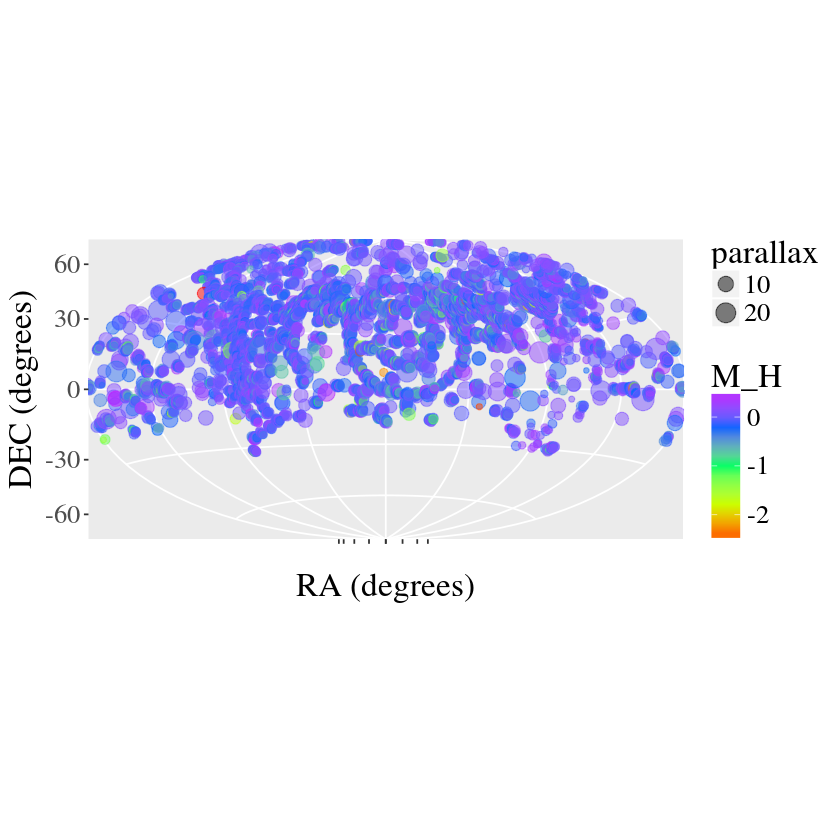

In [2]:
# Gather parameters of interest
myparams <- c('J','J_ERR','H','H_ERR','K','K_ERR',
              'TEFF','TEFF_ERR',
              'LOGG','LOGG_ERR',
              'M_H','M_H_ERR',
              'VHELIO_AVG','VERR',
              #Gaia Data
              'ra_x','ra_error','dec_x','dec_error',
              'phot_g_mean_mag',
              'l','b',
              'parallax','parallax_error',
              'pmra_x', 'pmra_error', 'pmdec_x', 'pmdec_error')

# Remove erroneous data - NaNs from both Gaia nad APOGEE sets
# while retainng my parameters of interest
df <- temp[temp$parallax >0 ,myparams]
df[df <= -9999.00] <- NA
df <- df[complete.cases(df), ]

# Rename G mag
names(df)[which(grepl('phot_g',names(df)))]="G"

# Get distance
df$kpc <- 1./(df$parallax)
df$kpc_err <- 1./(df$parallax_error)

# Wrap angles
df$ra_x <- df$ra_x - 180.0
df$l <- df$l -180.0

# Get locations of interesting parameters
errlocs <- which(grepl("err|ERR",names(df)))
parlocs <- which(!grepl("err|ERR|ID|\\bra_x\\b|\\bdec_x\\b|\\bkpc\\b|\\bb\\b|\\bl\\b",names(df)))

# Convert to galactic x, y, z
xyzcoords <- sph2car(df$l, df$b, radius = df$kpc,deg=T)
df$x <- xyzcoords[,1] ; df$y <- xyzcoords[,2] ; df$z <- xyzcoords[,3]

# Create projection of RA/DEC
sky2 = data.frame(RA=0, Dec=0)
ggplot(sky2,aes(x=RA,y=Dec))+
  coord_map(projection="aitoff",orientation=c(89.999,0,0)) +
  scale_y_continuous(breaks=(-2:2)*30,limits=c(-89.999,89.999)) +
  scale_x_continuous(breaks=(-4:4)*45,limits=c(-180,180),labels=c("","","","","","","","","")) +
  geom_point(data=df,aes(x=ra_x,y=dec_x,colour=M_H,size=parallax),alpha=0.5)+scale_color_gradientn(colours=rainbow(5))+
  theme(text = element_text(size=20,family="serif"))+labs(x = "RA (degrees)", y ="DEC (degrees)")

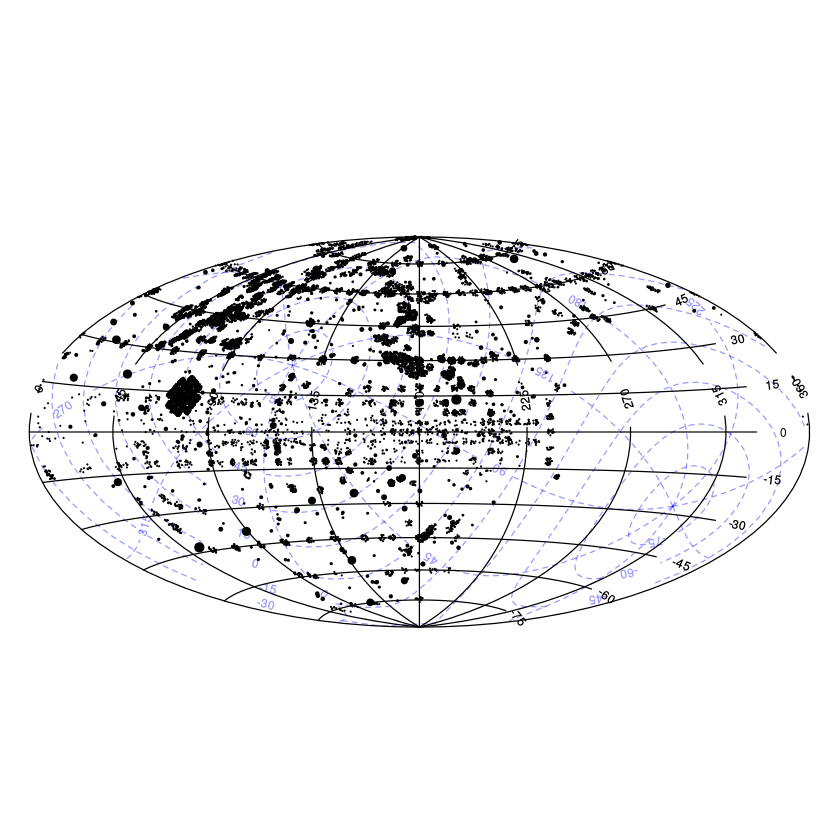

In [3]:
# Galactic projections
createAllSkyGridChart(mainGrid="galactic", eqDraw=T, eclDraw=F, galDraq=T,addLab=T,
                      galCol="black", eqCol=rgb(0,0,1,0.4), galLty=1, eqLty=2,main = "",xlab="l (degrees)",ylab="b (degrees)")
overplotScatterPlotInAllSkyGridChart(df$l, df$b,
                                     mainGrid="galactic", dataCoordSys="galactic", pointcol="black", pch=19,
                                     pointsize=df$parallax/max(df$parallax))

In [4]:
# Summary of the final data frame
print(paste("The dimensionality of our dataframe is: ",dim(df)[1],
            " rows by ",dim(df)[2],
            " columns.",sep=''))
print("The summary for each parameter follows:")
summary(df)

[1] "The dimensionality of our dataframe is: 15313 rows by 32 columns."
[1] "The summary for each parameter follows:"


       J              J_ERR               H              H_ERR        
 Min.   : 2.860   Min.   :0.01700   Min.   : 2.091   Min.   :0.01400  
 1st Qu.: 8.462   1st Qu.:0.02100   1st Qu.: 7.875   1st Qu.:0.01900  
 Median : 9.166   Median :0.02200   Median : 8.604   Median :0.02300  
 Mean   : 9.042   Mean   :0.02694   Mean   : 8.487   Mean   :0.02975  
 3rd Qu.: 9.754   3rd Qu.:0.02400   3rd Qu.: 9.224   3rd Qu.:0.03000  
 Max.   :11.747   Max.   :8.88800   Max.   :11.292   Max.   :9.99800  
       K              K_ERR              TEFF         TEFF_ERR     
 Min.   : 1.440   Min.   :0.01100   Min.   :3645   Min.   : 38.00  
 1st Qu.: 7.739   1st Qu.:0.01700   1st Qu.:4585   1st Qu.: 65.85  
 Median : 8.477   Median :0.01900   Median :4762   Median : 73.56  
 Mean   : 8.358   Mean   :0.02857   Mean   :4718   Mean   : 73.02  
 3rd Qu.: 9.107   3rd Qu.:0.02200   3rd Qu.:4902   3rd Qu.: 80.54  
 Max.   :11.197   Max.   :9.99800   Max.   :5635   Max.   :149.55  
      LOGG            LOGG_

In [5]:
# Test the normality of all errors
# First two columns are AD test, next two columns are Lillie test
do.call(rbind, lapply(df[,errlocs], function(x) c(ad.test(x)[c("statistic", "p.value")],
                                                  lillie.test(x)[c("statistic", "p.value")])))

,statistic,p.value,statistic,p.value
J_ERR,5206.988,3.7e-24,0.4626913,0
H_ERR,4640.124,3.7e-24,0.4443989,0
K_ERR,5600.163,3.7e-24,0.4763362,0
TEFF_ERR,45.05046,3.7e-24,0.03328041,1.429134e-43
LOGG_ERR,115.0437,3.7e-24,0.06259924,7.283249e-161
M_H_ERR,434.4221,3.7e-24,0.1045786,0
VERR,2840.742,3.7e-24,0.3369682,0
ra_error,2221.884,3.7e-24,0.2872419,0
dec_error,2241.425,3.7e-24,0.2642064,0
parallax_error,1179.155,3.7e-24,0.2012839,0


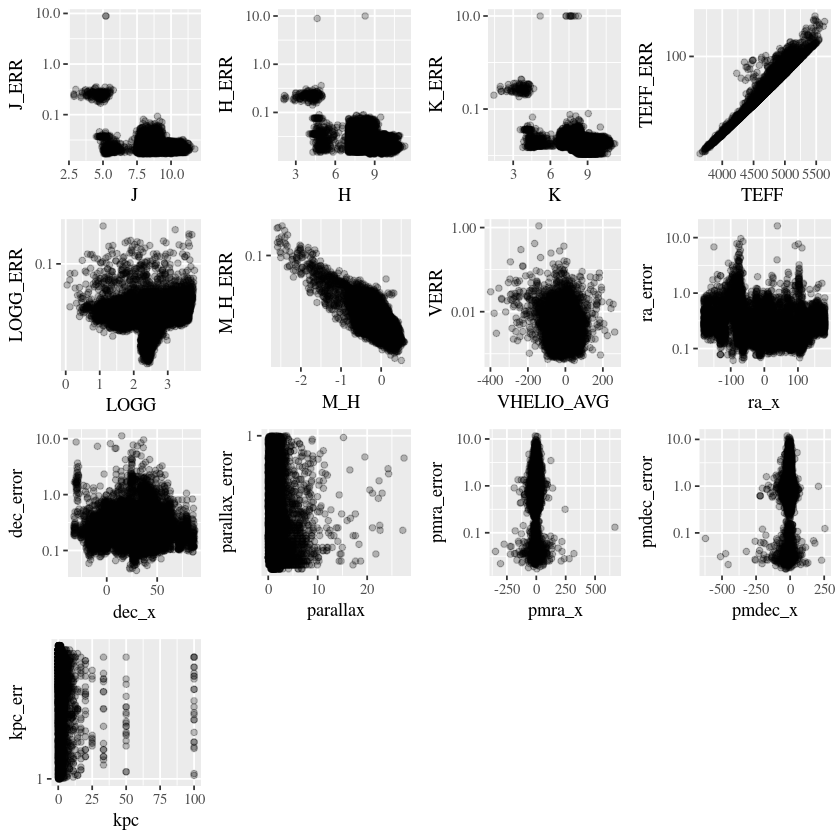

In [6]:
# Now we can plot each variable against its respective error
plots <- lapply(errlocs, function(column) {
  ggplot(df,aes_string(x=names(df)[column-1],y=names(df)[column]))+
  geom_point(alpha=0.25) + scale_y_log10()+
  labs(x = names(df)[column-1], y =names(df)[column])+
  theme(text = element_text(family="serif"))}) %>% 
  do.call(grid.arrange, .)

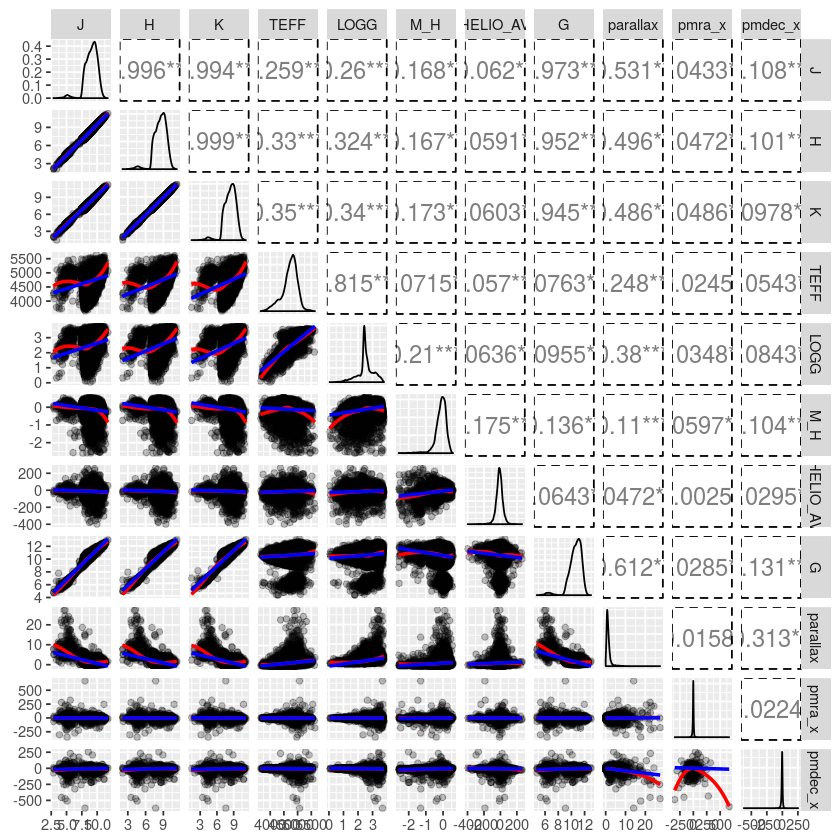

In [7]:
# Now we can look at the correlation among the various parameters
source("ggally_cor.R")
assignInNamespace("ggally_cor", ggally_cor, "GGally")
my_fn <- function(data, mapping, ...){
  p <- ggplot(data = data, mapping = mapping) + 
    geom_point(alpha=0.25) + 
    geom_smooth(method=loess, fill="red", color="red", ...) +
    geom_smooth(method=lm, fill="blue", color="blue", ...)
  p
}
g <- ggpairs(df[,parlocs],lower = list(continuous = my_fn), upper = list(continuous = wrap("cor")))
g

In [8]:
# Now we can run PCA
# Perform preprocessing for scaling, applying a Box-Cox transformation to correct for skewness,
# center and scale each color and magnitude
df.trans <- preProcess(df[,parlocs], method=c("BoxCox", "center", "scale","pca"))
df.pca <- predict(df.trans,newdata = df[,parlocs])
print(df.trans)
print(summary(df.pca))

Created from 15313 samples and 11 variables

Pre-processing:
  - Box-Cox transformation (7)
  - centered (11)
  - ignored (0)
  - principal component signal extraction (11)
  - scaled (11)

Lambda estimates for Box-Cox transformation:
2, 2, 2, 2, 1.6, 2, 0.1
PCA needed 6 components to capture 95 percent of the variance
      PC1               PC2                PC3                PC4           
 Min.   :-9.2484   Min.   :-7.37670   Min.   :-18.1094   Min.   :-47.57488  
 1st Qu.:-1.3616   1st Qu.:-0.72831   1st Qu.: -0.3321   1st Qu.: -0.29227  
 Median : 0.1241   Median : 0.05786   Median :  0.1813   Median : -0.04251  
 Mean   : 0.0000   Mean   : 0.00000   Mean   :  0.0000   Mean   :  0.00000  
 3rd Qu.: 1.4727   3rd Qu.: 0.85752   3rd Qu.:  0.5909   3rd Qu.:  0.24954  
 Max.   : 6.4002   Max.   : 8.33411   Max.   :  6.7709   Max.   : 16.08761  
      PC5                 PC6           
 Min.   :-13.50806   Min.   :-16.66257  
 1st Qu.: -0.49662   1st Qu.: -0.52652  
 Median : -0.0185

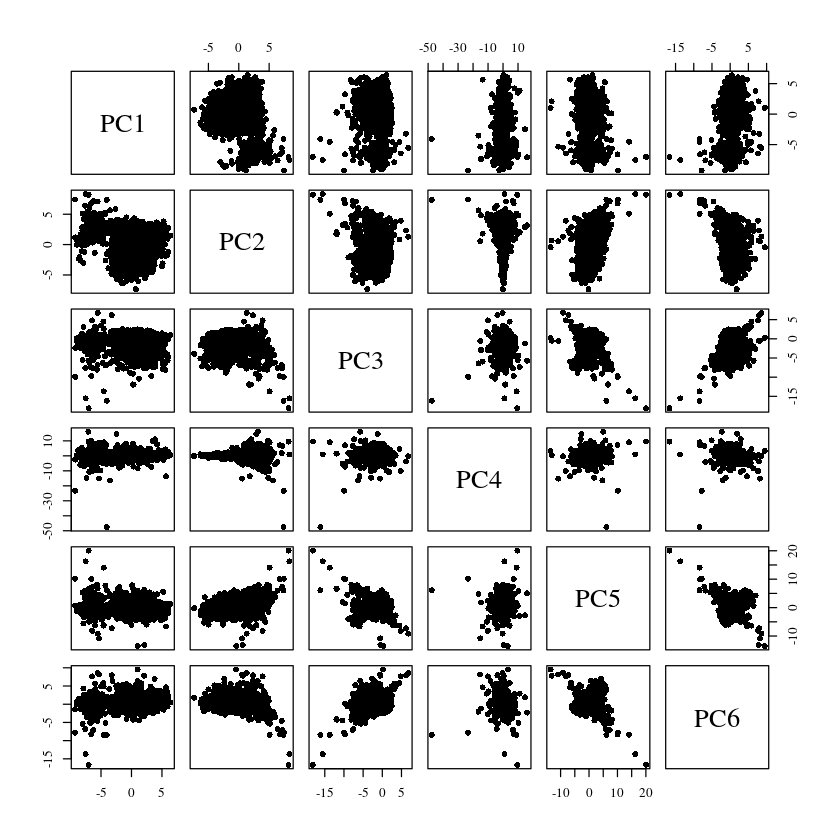

In [9]:
# We can plot the PCs
par(family='serif',cex.lab=1.5)
plot(df.pca,pch=16)

In [11]:
# Run with Earth to see some parameters
scaleddf <- df[,parlocs] %>% mutate_each_(funs(scale(.) %>% as.vector),vars=names(df)[parlocs])
mars <- earth(M_H ~ . -M_H, data=scaleddf)
# Print AD values
print(paste("The residuals for the earth regression have a p-value of: ",
            ad.test(mars$residuals)$p.value,' for the AD normality test.',sep=''))

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


[1] "The residuals for the earth regression have a p-value of: 3.7e-24 for the AD normality test."


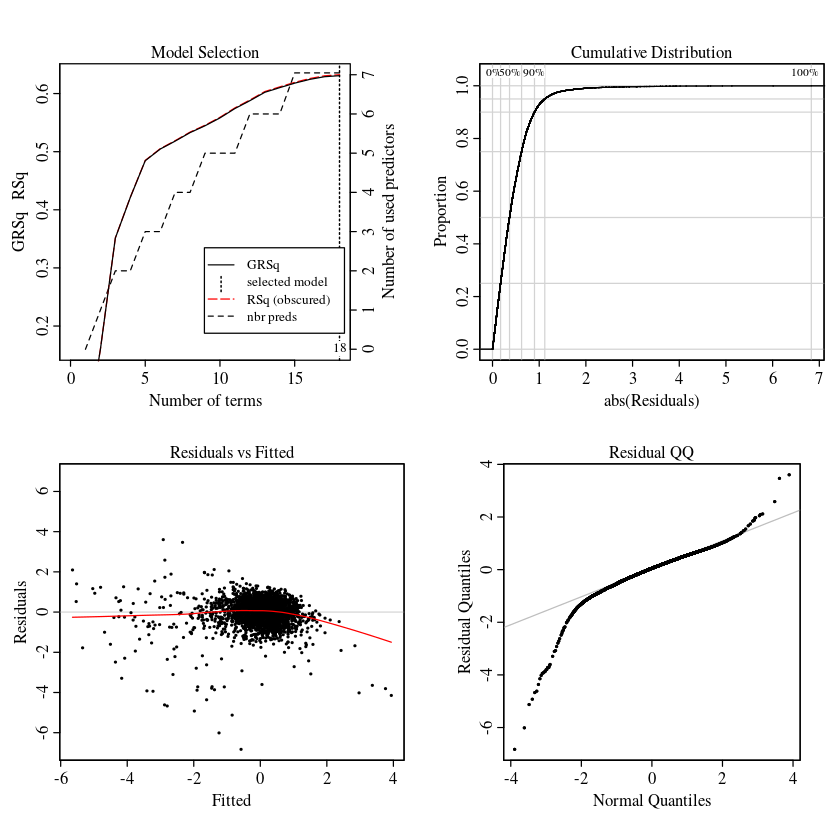

In [12]:
# Plot diagnostics
par(family='serif')
plot(mars,caption='')

 plotmo grid:    J         H         K      TEFF        LOGG VHELIO_AVG
         0.1192944 0.1093306 0.1094571 0.1583708 -0.05640042 0.03107869
         G   parallax     pmra_x   pmdec_x
 0.1478072 -0.2194313 0.04794653 0.0905756


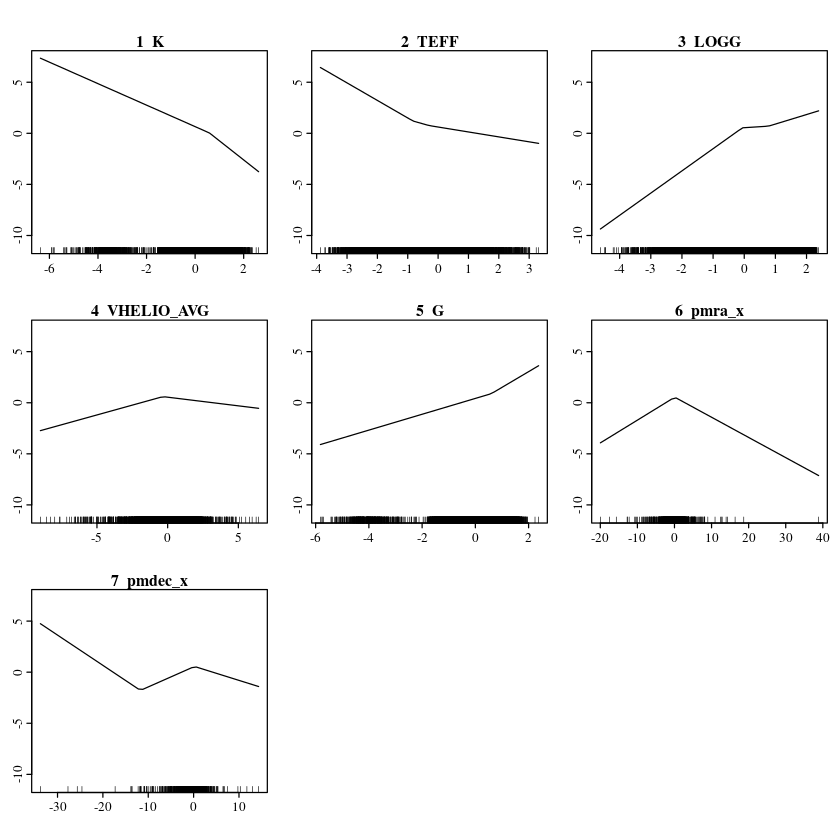

In [13]:
# Plot responses
par(family='serif',cex=1.5)
plotmo(mars, nrug=-1, caption='',all1=TRUE)

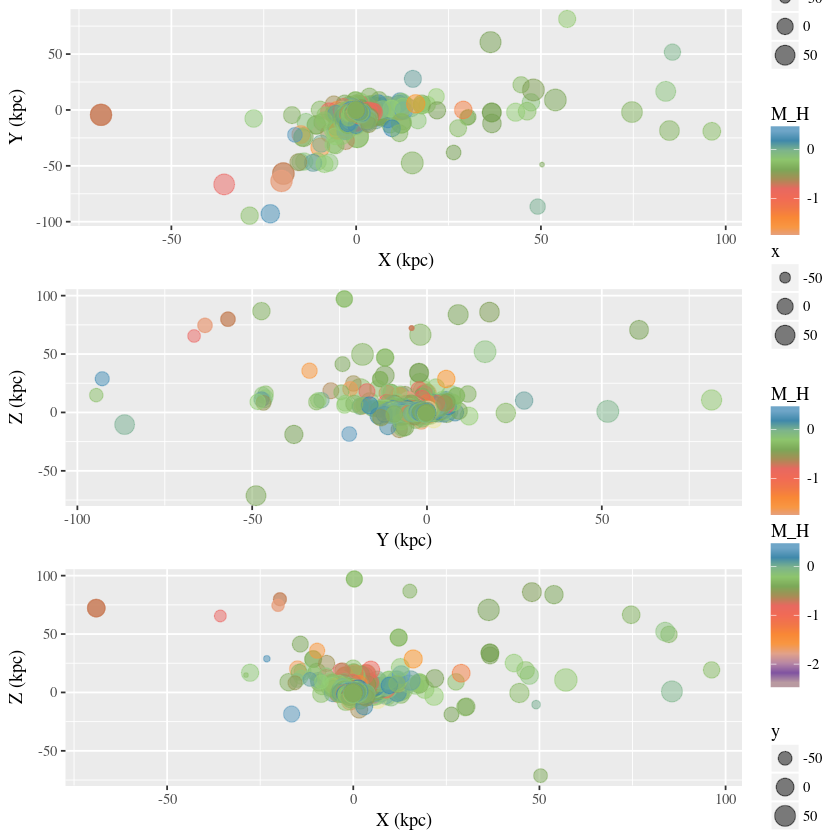

In [14]:
# Spatial distribution
my.colors <- colorRampPalette(rev(brewer.pal(11, "Paired")))
spatlocs <- c((length(df)-2):(length(df)-1))
p1 <- ggplot(df, aes(x = x, y = y, size = z,colour=M_H))+geom_point(alpha=0.5) +
  scale_colour_gradientn(colours = my.colors(10)) + labs(x = "X (kpc)", y ="Y (kpc)")+ theme(text = element_text(family="serif"))
p2 <- ggplot(df, aes(x = y, y = z, size = x,colour=M_H))+geom_point(alpha=0.5) +
  scale_colour_gradientn(colours = my.colors(10)) + labs(x = "Y (kpc)", y ="Z (kpc)")+ theme(text = element_text(family="serif"))
p3 <- ggplot(df, aes(x = x, y = z, size = y,colour=M_H))+geom_point(alpha=0.5) +
  scale_colour_gradientn(colours = my.colors(10)) + labs(x = "X (kpc)", y ="Z (kpc)")+ theme(text = element_text(family="serif"))
grid.arrange(p1,p2,p3)

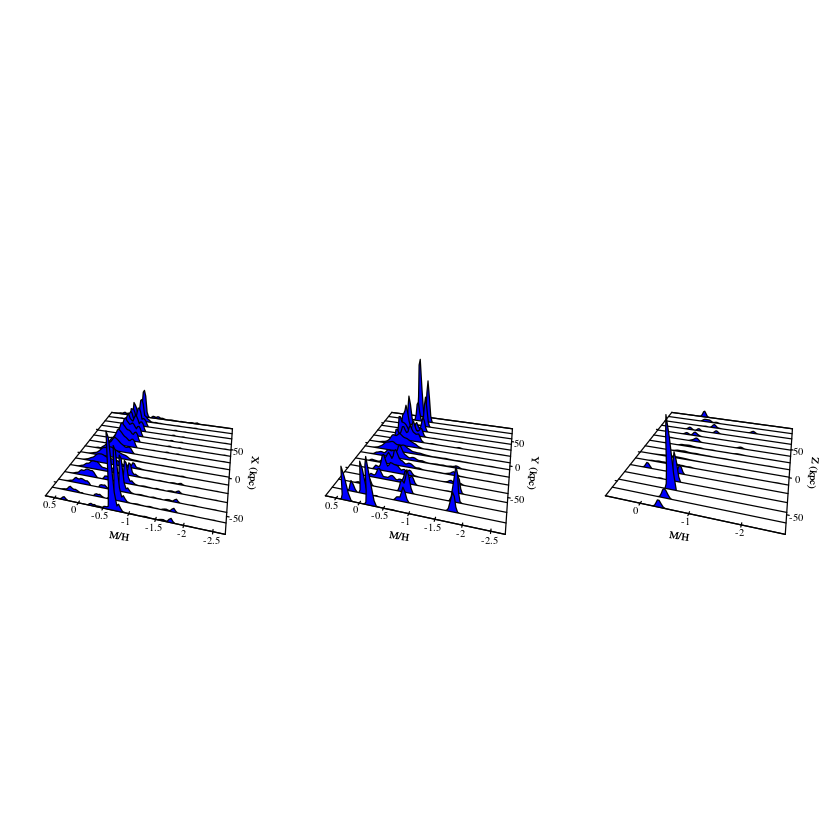

In [15]:
# KDE for metallicity
gal.x <- cde(df$x,df$M_H,x.name="X (kpc)",  y.name="M/H", deg=2)
gal.y <- cde(df$y,df$M_H,x.name="Y (kpc)",  y.name="M/H", deg=2)
gal.z <- cde(df$z,df$M_H,x.name="Z (kpc)",  y.name="M/H", deg=2)
par(family='serif',cex.lab=1.5,mfrow=c(1,3))
plot(gal.x)
plot(gal.y)
plot(gal.z)

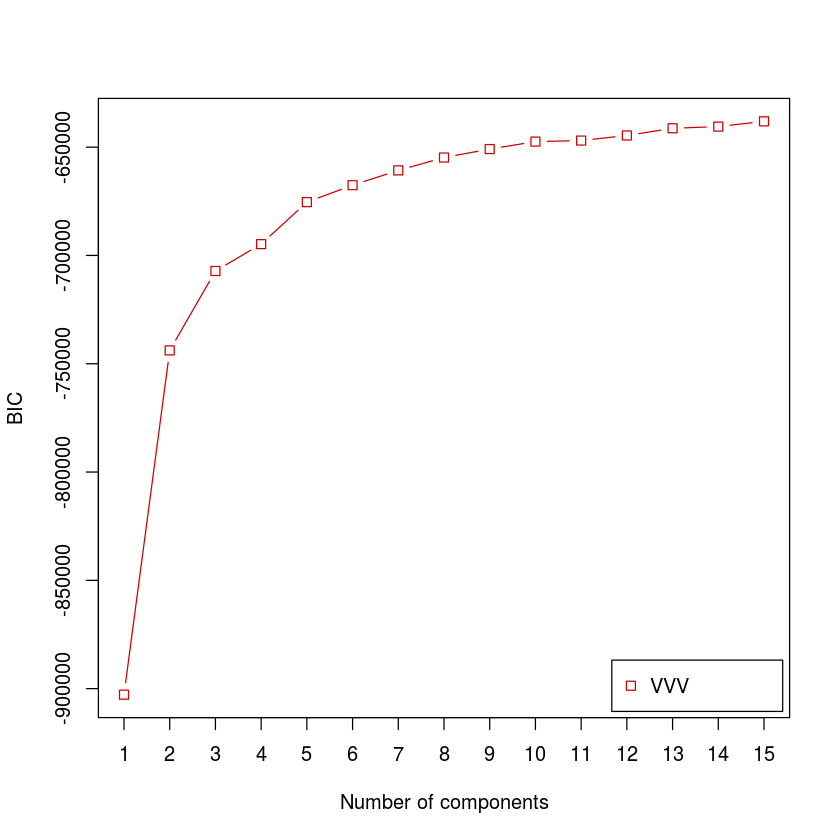

In [16]:
# Search for spatial clusters and plot BIC
whichparam <- grepl("\\bK\\b|\\bTEFF\\b|\\bM_H\\b|\\bLOGG\\b|\\bVHELIO_AVG\\b|\\bG\\b|\\bpmra_x\\b|\\bpmdec_x\\b|\\bx\\b|\\by\\b|\\bz\\b",names(df))
mle.clus.colors <- Mclust(df[,whichparam], modelNames='VVV',hcUse='VARS',G=1:15)
plot(mle.clus.colors, what = "BIC")

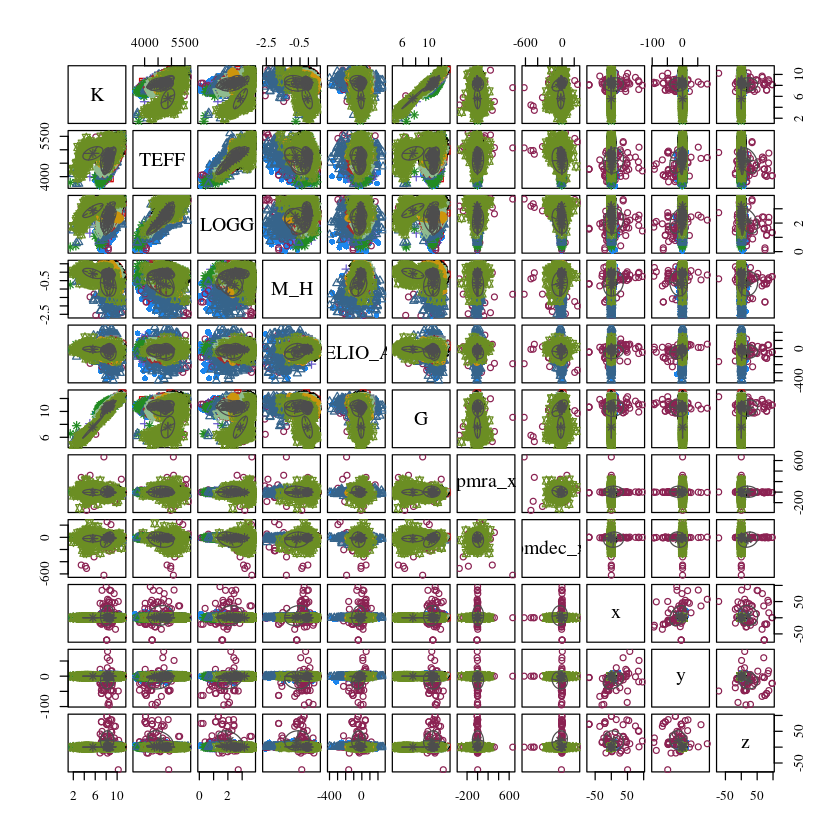

In [17]:
# Plot the classification
par(family='serif')
plot(mle.clus.colors, what = "classification")

Warning message:
“data contain duplicated points”

Generating 99 simulations of CSR  ...
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,  99.

Done.
Generating 99 simulated realisations of fitted Gibbs model  ...
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,  99.

Done.


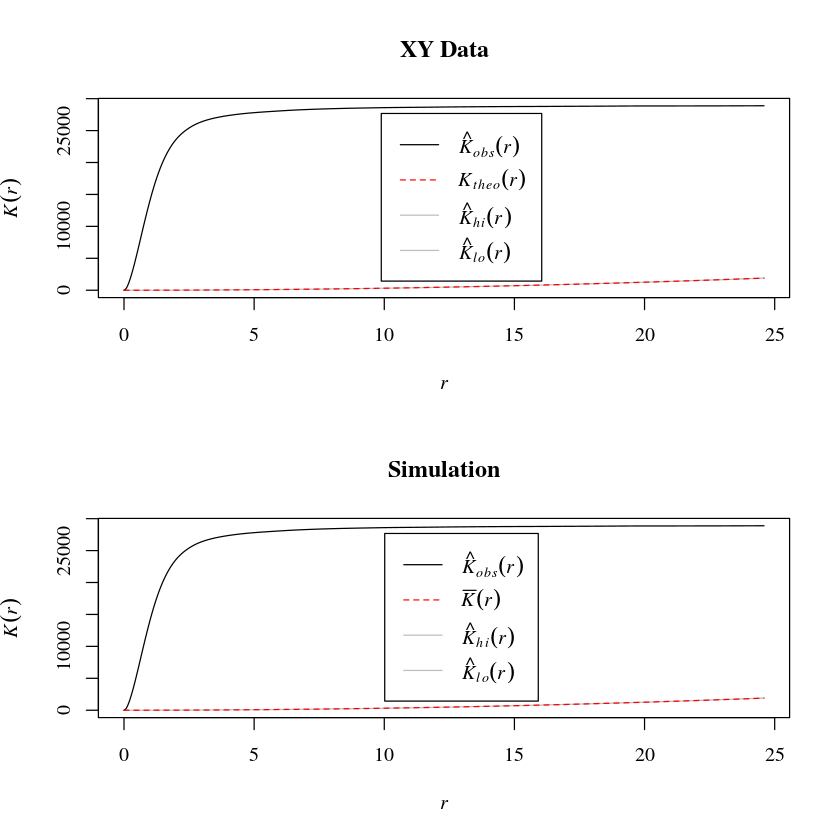

In [18]:
# Using spatstat
mypattern <- ppp(df$x, df$y,
                 c(min(df$x),max(df$x)),
                 c(min(df$y),max(df$y)))

# Fitting the spatial data with a simple Strauss process
interactionrad <- (max(df$x)-min(df$x))*0.01
fit <- ppm(Q = mypattern, trend = ~1, Strauss(interactionrad))

# Plotting Ripley's K function
par(family='serif',mfrow=c(2,1))
plot(envelope(mypattern,Kest),main="XY Data")
plot(envelope(fit,Kest),main="Simulation")

Warning message:
“data contain duplicated points”Warning message:
“data contain duplicated points”Warning message in Smooth.ppp(mypattern, 4):
“Numerical underflow detected: sigma is probably too small”Warning message in Smooth.ppp(mypattern2, 4):
“Numerical underflow detected: sigma is probably too small”Warning message in Smooth.ppp(mypattern3, 4):
“Numerical underflow detected: sigma is probably too small”

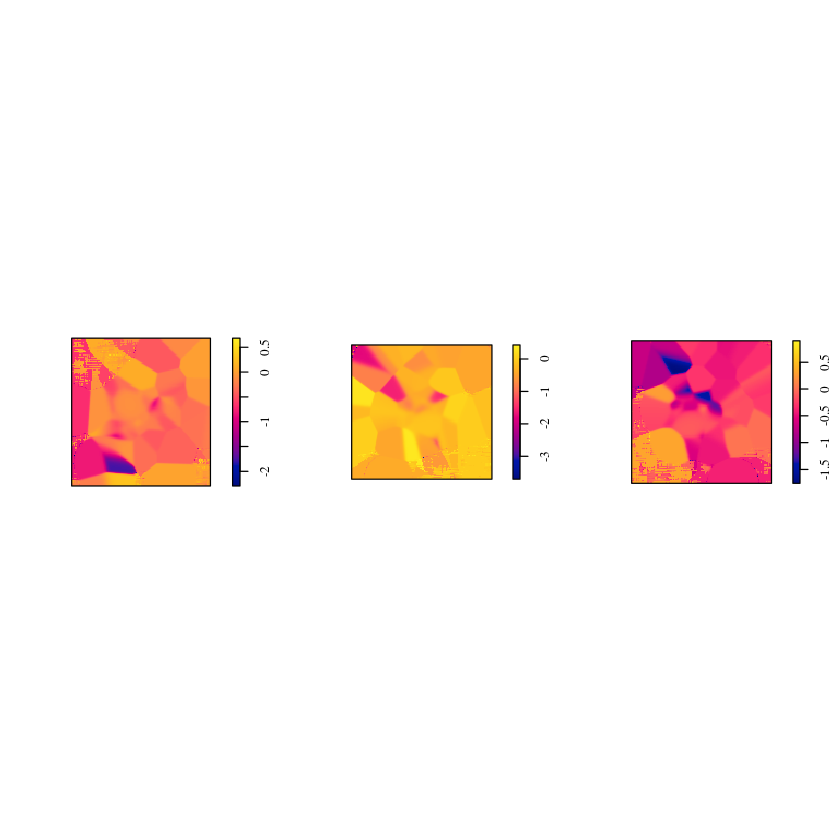

In [19]:
# Plot pixel of metallicity in cross-sections
marks(mypattern) = df$M_H
mypattern2 <- ppp(df$y, df$z,c(min(df$y),max(df$y)),c(min(df$z),max(df$z)))
marks(mypattern2) = df$M_H
mypattern3 <- ppp(df$x, df$z,c(min(df$x),max(df$x)),c(min(df$z),max(df$z)))
marks(mypattern3) = df$M_H

par(family='serif',mfrow=c(1,3))
plot(Smooth(mypattern, 4),main="")
plot(Smooth(mypattern2, 4),main="")
plot(Smooth(mypattern3, 4),main="")